In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import numpy as np
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
import math
plt.rcParams['font.sans-serif'] = ['SimHei']
pd.options.display.notebook_repr_html=False  # 表格显示
plt.rcParams['figure.dpi'] = 75  # 图形分辨率
sns.set_theme(style="darkgrid")
import shap

In [2]:
# 读入数据
data = pd.read_excel('../data/机器学习特征工程_V3.xlsx')

In [3]:
#设计一个机器学习训练函数，输入需要预测的次数，返回模型本身
def mech_learning(df2,try_num):

    Y = df2[[try_num]]
    X = df2.drop(['1 try','2 tries','3 tries','4 tries','5 tries','6 tries','7 or more tries (X)'],axis=1)


    X_train, X_test, y_train, y_test =  train_test_split(X, Y, test_size=0.2, random_state=1)
    #, random_state=1
    params = {
        'learning_rate': [0.01, 0.1,0,2,1],
        'n_estimators': [20,50,100],
        'max_depth': [2,3,5],
        'min_samples_leaf' :[1, 2,5]
    }
    gbdt_reg = GradientBoostingRegressor(random_state=1)
    grid_search = GridSearchCV(gbdt_reg, param_grid=params,
                            scoring='neg_mean_absolute_error', cv=10, n_jobs=2)

    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print("通过GridSearchCV获得的最优参数为： \n", best_params)

    gbdt_reg_opt = GradientBoostingRegressor(
        learning_rate=best_params['learning_rate'],
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        random_state=1
    )

    gbdt_reg_opt.fit(X_train, y_train)
    return gbdt_reg_opt,X_train, X_test, y_train, y_test

In [4]:
#在此处计算模型
name = ['1 try','2 tries','3 tries','4 tries','5 tries','6 tries','7 or more tries (X)']
try_num = name[2]
#'7 or more tries (X)'
model,X_train, X_test, y_train, y_test = mech_learning(data,try_num)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)#训练集的预测准确性
MAE_test = mean_absolute_error(y_test, y_pred)
R2_test = r2_score(y_test, y_pred)
R2_train = r2_score(y_train, y_pred_train)
MAE_train = mean_absolute_error(y_train,y_pred_train)

print(try_num,'训练集拟合优度为',R2_train)
print(try_num,'测试集拟合优度为',R2_test)
print(try_num,"在训练集上的MSE为：%f" % MAE_train)
print(try_num,"在测试集上的MSE为：%f" % MAE_test)

通过GridSearchCV获得的最优参数为： 
 {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 100}
3 tries 训练集拟合优度为 0.8731718937379691
3 tries 测试集拟合优度为 0.4788931898392157
3 tries 在训练集上的MSE为：2.139033
3 tries 在测试集上的MSE为：4.841999


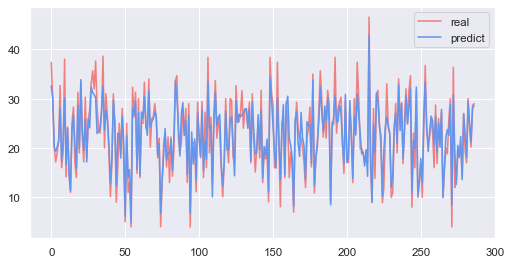

In [5]:
#作图
plt.figure(figsize=(8,4))
sns.lineplot(data = np.array(y_train[try_num]),color = 'lightcoral',label = 'real')
sns.lineplot(data = y_pred_train,color = 'cornflowerblue',label = 'predict')
plt.legend()
#plt.savefig('../latex/pic/'+try_num + '训练图.png')

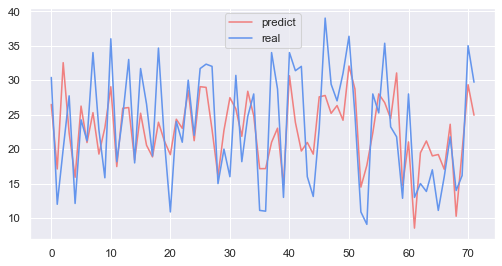

In [6]:
#作图
plt.figure(figsize=(8,4))
sns.lineplot(data = y_pred,color = 'lightcoral',label = 'predict')
sns.lineplot(data = np.array(y_test[try_num]),color = 'cornflowerblue',label = 'real')
plt.legend()
#plt.savefig('../latex/pic/'+try_num + '测试图.png')

In [7]:
#存放模型结果

file_name = '../data/predict/'+ try_num + 'test_predict.xlsx'
pred_test_data = pd.DataFrame(data = y_pred)
pred_test_data.to_excel(file_name)


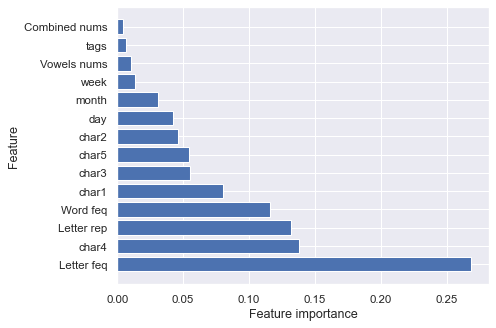

In [8]:
# 5. 特征重要性
fea_sort = pd.DataFrame()
fea_sort['特征'] = X_train.columns
fea_sort['特征重要性'] = model.feature_importances_
fea_sort.sort_values('特征重要性', ascending=False, inplace=True)
# 将特征重要性以柱状图的形式显示出来
n_features = len(fea_sort['特征'])
plt.barh(range(n_features), fea_sort['特征重要性'], align='center')
plt.yticks(range(n_features), fea_sort['特征'])
plt.xlabel("Feature importance")
plt.ylabel("Feature")
#plt.savefig('Q2/trying_GBDT_feas_importance.pdf', dpi=600,
            #format='jpg', bbox_inches='tight')
plt.show()



In [9]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)


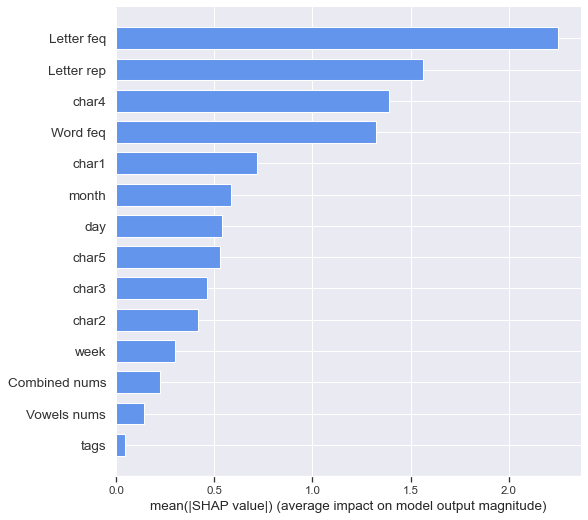

In [10]:
shap.summary_plot(shap_values, X_train, plot_type="bar",color = 'cornflowerblue')

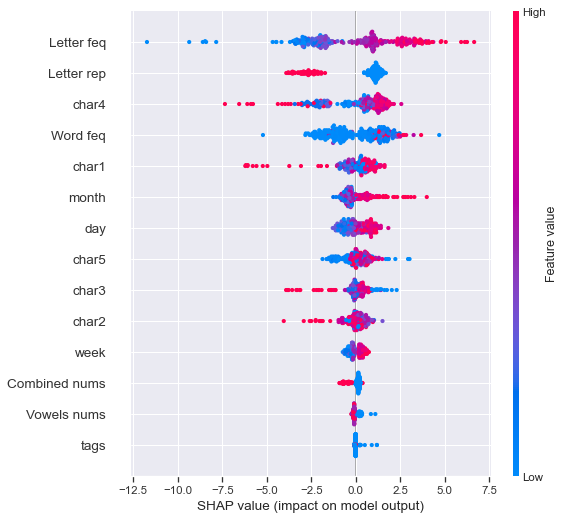

In [11]:
shap.summary_plot(shap_values, X_train)

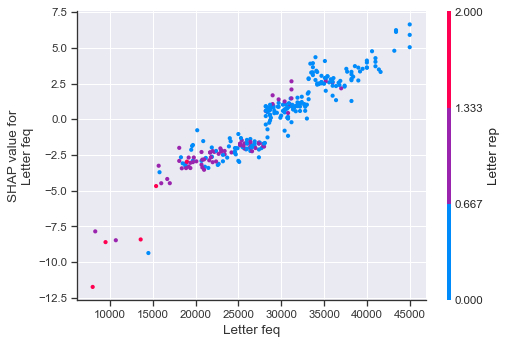

In [12]:
shap.dependence_plot('Letter feq', shap_values, X_train, interaction_index='Letter rep')

In [13]:
#针对特定单词的训练
x_word = pd.DataFrame(data = {"tag":[1],
"week" :[2],
'char1':[4],
'char2':[4],
'char3':[17],
'char4':[8],
'char5':[4],
'Word feq':[2272],
'Vowels nums':[4],
'Combined nums':[1],
'Letter feq':[50200],
'Letter rep':[2],
'month' : [3],
'day' : [1]
})
x_word

   tag  week  char1  char2  char3  char4  char5  Word feq  Vowels nums  \
0    1     2      4      4     17      8      4      2272            4   

   Combined nums  Letter feq  Letter rep  month  day  
0              1       50200           2      3    1  

In [14]:
shap_values = explainer.shap_values(x_word)
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0:1,:], x_word.iloc[0:1,:])

In [15]:
y_word_pred = model.predict(x_word)
print(try_num ,'下预测的百分率为',y_word_pred)

3 tries 下预测的百分率为 [23.73698471]
